Number of raw time-points =  1024
(2048, 1)
Number of time-points after zero-pad = 2048
Mean of time series =  -11.79735004078369


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


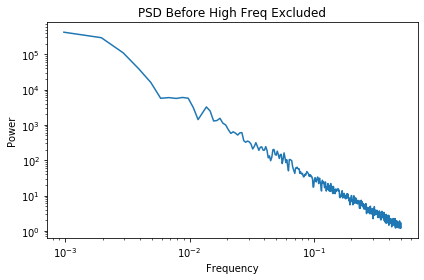

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


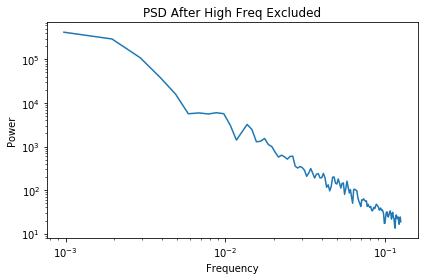

Output Parameters of Fractal Analysis of Time Series:
Beta =  2.1259600601893043
Correlation coefficient =  -0.9917039349433046
Signal is class 2: fBm
H_PSD =  0.5629800300946521
H_Disp =  -1
H_bdSWV =  0.6936013352520579
H_fGn =  -1
H_fBm =  0.628290682673355


In [137]:
#Load signal from sample fMRI (SCI_Pilot_08)
#these signals have a grey mask applied
fbm_sample = np.loadtxt(fname="Test_Signals/sig_fbm_sample.csv", delimiter =",")
fgn_sample = np.loadtxt(fname="Test_Signals/sig_fGn_sample.csv", delimiter =",")
SSC_fbm_sample = np.loadtxt(fname="Test_Signals/sig_SSC_fBm_sample.csv", delimiter =",")
SSC_fgn_sample = np.loadtxt(fname="Test_Signals/sig_SSC_fgn_sample.csv", delimiter =",")
noclass_sample = np.loadtxt(fname="Test_Signals/sig_noclass_sample.csv", delimiter =",")

#turn 1D array into 2D array and transpose so single column vector 
fbm_sample_T = np.reshape(fbm_sample,(fbm_sample.size, 1))
fgn_sample_T = np.reshape(fgn_sample,(fgn_sample.size, 1))
SSC_fbm_sample_T = np.reshape(SSC_fbm_sample,(SSC_fbm_sample.size, 1))
SSC_fgn_sample_T = np.reshape(SSC_fgn_sample,(SSC_fgn_sample.size, 1))
noclass_sample_T = np.reshape(noclass_sample,(noclass_sample.size, 1))


#functioncall
#FracTool(noclass_sample_T)


#Loads fbm signal of known Hurst coeffecient 
#Hurst coeff is 0.7 and signal has 1024 timepoints
fBm_knownH = np.loadtxt(fname="Test_Signals/sig_fbm_knownH.csv", delimiter =",")
#turn 1D array into 2D array and transpose so single column vector 
fBm_knownH_T = np.reshape(fBm_knownH,(fBm_knownH.size, 1))
#function call
FracTool(fBm_knownH_T)

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.fftpack import fft, ifft

def Window(ts):
    '''This function applies a parabolic window to the signal input'''
    n = len(ts) #n is length of time series
    W = np.zeros((n,1)) #initialize empty array
    #create parabola from 0 to length n
    for j in np.arange(0,n):
        W[j] = 1 - np.power((2*(j + 1)/(n+1)-1),2)
    #multiply parabola and signal to get windowed signal (result)
    result = ts * W 
    return result

def Bridge(ts):
    '''This function bridge detrends the signal input ts
    The function subtracts a line connecting the first and last points from the signal'''
    n = len(ts)
    #points is the length of the time series from n-1 to 0 (backwards i.e. n-1, n-2,...0)
    points = np.arange(n-1, -1, -1).reshape(1,n)
    #line is a straight line connecting first and last point
    line = ((ts[0]-ts[n-1])*points/(n-1))+ts[n-1]
    line = line.transpose() #transposes line from row to column array
    #subtract line from time series to return bridge detrended signal (result)
    result = ts - line
    return result 

def Linreg(x,y):
    '''This function calculates the slope and correlation coefficient of a linear fit model
    result[0]: Slope
    result[1]: Correlation coefficient'''
    #calculate mean of x and y (lgfrek and lgPyy when called in FracTool)
    mikro = np.mean(x) #mean of lgfrek
    nu = np.mean(y) #mean of lgPyy
    mikro_sub = x - mikro #subtract lgfrek mean from lgfrek array 
    nu_sub = y - nu #subtract lgPyy mean from lgPyy array
    #multiply mean-subtracted arrays and add sum of elements 
    Qxy = np.sum(mikro_sub*nu_sub)
    Qx = sum(mikro_sub**2) #sum of sqaured differences of lgfrek
    Qy = sum((nu_sub**2)) #sum of squared differences of lgPyy
    result = np.empty([2,1]) #initialize empty result array
    result[0] = Qxy/Qx #slope of linear regression
    result[1] = Qxy/(Qx*Qy)**0.5 #correlation coefficient of linear regression
    
    return result
 
    
def Spec(ts, p, avg): 
    '''This function performs a spectral analysis of the time series
    where ts is the time series, p is the nth power of 2 where 2^n<=length
    of time series. If avg=0, then spectra for all, if avg=1, then spectra avg.
    An array of the following results will be returned.
    result[0]: Hurst coefficient
    result[1]: correlation coefficient
    result[2]: beta from Fourier analysis
    result[3]: Hurst coefficient (high freq excluded)
    result[4]: correlation coefficient (high freq excluded)
    result[5]: beta from Fourier analysis (high freq excluded)'''
    #initialize empty array for results outlined above
    result = np.empty([6,1])
    f = 1
    n = 2**p #p is the greatest integer where 2^p < n 
    
    #compute the estimated power of time series (Pyy):
    
    #compute the discrete fourier transform of time series 
    Y = scipy.fftpack.fft(ts.flatten()) #time series needs to be 1D (flattened from 2D)
    Y_conj = Y.conj() #return conjucate of every element in Y, eg. conj() of a+bi is a-bi
    Pyy = Y*Y_conj/n #multiply Y by conj of Y to get absolute value of Y, squared, then divide by length
    Pyy = Pyy[0:int(n/2)] #splice array to only include have first half (it is symmetric)
    Pyy = np.reshape(Pyy, (Pyy.size,1)) #convert Pyy to column array
    
    #clear arrays that are no longer used
    Y = []
    Y_conj = []
    y = []
    
    #generate array of frequencies from 0 to 0.5 (frek)
    frek = f/n*np.arange(1,(n/2)+1)
    frek = np.reshape(frek, (frek.size,1)) #transpose frek to column array 
        
    #if avg=1, then average frek and Pyy before taking spectra
    if avg == 1: 
        #initialize empty 1D arrays
        ff = np.zeros((1,p-1)).flatten()
        pp = np.zeros((1,p-1)).flatten()
        #for loop takes mean of ranges between 2^0 and 2^p
        #output is arrays ff and pp where each element of the array is average of ranges i.e. [avg(2^0-(2^1)-1), avg(2^1-(2^2)-1), ..., avg(2^(p-1)-(2^p)-1)]
        for i in range(1,p):
            #each element in ff is mean of frek from 2^(i-1) to (2^i) - 1 until i = p
            ff[i-1]=np.mean(frek[2**(i-1)-1:2**i-1])
            #each element in pp is mean of Pyy from 2^(i-1) to (2^i) - 1 until i = p
            pp[i-1]=np.mean(Pyy[2**(i-1)-1:2**i-1])
        #clear Pyy and frek and set value to pp and ff omitting first index
        Pyy=[] #clear Pyy
        Pyy = pp[1:len(pp)]
        Pyy = np.reshape(Pyy, (Pyy.size,1)) #convert into 2D array
        frek=[] #clear frek
        frek=ff[1:len(pp)]
        frek = np.reshape(frek,(frek.size,1)) #convert into 2D array
        #now spectra will be of average frek and Pyy values, not all values
      

    #find where Pyy has values of 0, set those values to 0.00001 before taking log
    k = np.where(Pyy==0)
    if len(k)!=0: #if there are values where Pyy = 0
        for kk in range(1,len(k)+1):
            Pyy[k[kk-1]] = 0.00001
            
    #take natural log of Pyy and frek
    lgPyy = np.log(Pyy)
    lgfrek = np.log(frek)
    
    #power spectral density (PSD) plot 
    plt.title('PSD Before High Freq Excluded')
    plt.semilogx(frek, Pyy)
    plt.yscale('log')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.tight_layout()
    plt.show()
    
    #compute linear regression of PSD
    #curvefit returns an array of 2 values: (1) slope from lin regression, (2) correlation coeff from lin regression
    curvefit = Linreg(lgfrek,lgPyy)
    #set result values to curvefit results (according to indices outlined in function definition)
    result[2] = curvefit[0,0]*-1  #Beta has opposite sign as slope 
    result[1] = curvefit[1,0]   #Correlation coeff
    #calculate Hurst coefficient based on value of Beta
    if result[2]<1: #if Beta is less than 1, then Hurst coefficient is: 
        result[0] = (result[2]+1)/2 #signal is fGn, H_PSD = (Beta + 1)/2
    elif result[2]>1: #if Beta is greater than 1, then Hurst coefficient is: 
        result[0] = (result[2]-1)/2 #signal is fBm, H_PSD = (Beta - 1)/2
    elif result[2]==1: #if Beta is equal to 1, set Hurst to infinity
        result[0] = inf 
        
    #results 0,1,2 are the Hurst coeff, correlation coeff, and Beta of the raw signal (before high freqs excluded)
    #now will exclude frequencies between 1/8 and 1/2Hz to determine results 4,5,6

    #if avg=1, then exclue the last two values of lgfrek and lgPyy and then perform linear regression
    if avg == 1: 
        curvefit = Linreg(lgfrek[0:len(lgfrek)-2], lgPyy[0:len(lgPyy)-2])
    
    #if avg=0, exclude frequencies from 0.125Hz-0.5Hz and then perform linear regression 
    else:
        curvefit = Linreg(lgfrek[0:int(np.floor(len(lgfrek)/4))],lgPyy[0:int(np.floor(len(lgPyy)/4))])
    
    #plot of PSD after high frequencies are excluded
    plt.title('PSD After High Freq Excluded')
    plt.semilogx(frek[0:int(np.floor(len(lgfrek)/4))], Pyy[0:int(np.floor(len(lgPyy)/4))])
    plt.yscale('log')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.tight_layout()
    plt.show()
    
    #results of curvefit with high frequencies excluded
    result[5] = curvefit[0,0]*-1 #Beta
    result[4] = curvefit[1,0] #correlation coefficient
    
    #determine Hurst coefficient from Beta found after excluding high frequencies
    if result[5]<1: #if Beta is less than 1
        result[3] = (result[5]+1)/2
    elif result[5]>1: #if Beta is greater than 1
        result[3] = (result[5]-1)/2 #signal is fGn, H_PSD = (Beta + 1)/2
    elif result[5]==1: #if Beta is equal to 1, set Hurst coefficient to infinity 
        result[0] = inf #signal is fBm, H_PSD = (Beta - 1)/2
        
    return result #result is array of the 6 values (results[0] to results[5])

def Stdn(x):
    '''Standard deviation computes the "population" standard deviation, that is, it is 
    normalized by N, where N is the sequence length'''
    mikro = np.mean(x) #mean of time series
    
    n = len(x) #length of time series
    result = (np.sum((x-mikro)**2)/n)**0.5 #standard deviation formula 
   
    return result

def Disper(ts, p):
    '''This function performs dispersional analysis on time series. Dispersion is a measure
    of how much a distribution is stretched or squeezed.
    result[0]: Hurst coefficient
    result[1]: correlation coefficient (r) from linear regression'''
    used = p - 3 #the number of data points used in curve fit, excludes 1/2,1/4,1/8 frequencies
   
    lgsd = np.empty((1,used)).flatten() #initialize empty arrays for for-loop
    lgn = np.empty((1,used)).flatten()
    for i in range(1,used+1): #increment by orders of 2 (scales)
        lgsd[i-1] = np.log(Stdn(ts)) #calculates log of standard deviation of each scale
        lgn[i-1] = np.log(2**i) #natural log of bin size
        tsid = (ts[0:len(ts)-1:2] + ts[1:len(ts):2])/2 #odd time-points + even time-points/2 (avg between points)
        ts = []
        ts = tsid #reset ts to new time-signal which is half the length and the average between points.
        tsid = []
    #lgsd is the natural log of the standard deviation
    #lgn is the natural log of the bin size
    curvefit = Linreg(lgn, lgsd) #compute linear regression 
    result = np.empty((1,2)).flatten() #initialize empty results vector
    result[0] = 1 + curvefit[0] #Hurst coeff - 1 + slope of linear regression
    result[1] = curvefit[1] #correlation coeff of linear regression 
    return result

def Bdswv(ts, p): 
    '''This function performs bridge detrended scaled window variance analysis on an fBm 
    time series'''
    #ignored: column 0 is length, column 1 is smallest bin size, column 2 is largest bin size
    #these are the smallest/largest bins that will be ignored
    #for longer time series (larger p), more bins are ignored
    ignored = np.matrix([[6, 1, 0], [7, 1, 0], [8, 1, 0], [9, 2, 2], [10, 2, 3], [11, 2, 4], [12, 2, 4], [13, 2, 5], [14, 3, 6], [15, 3, 7], [16, 3, 7], [17, 3, 7], [18, 3, 7]])
    #while loop stops once p is equal to a length in column 0
    #smallest and largest are the values in the same row as this length 
    i = 1
    while p >= ignored[i-1,0]:
        smallest = ignored[i-1,1]
        largest = ignored[i-1,2]
        i = i + 1
    #smallest: ignore these smallest bin sizes
    #largest: ignore these largest bin sizes
    #example: p = 10, smallest is 2, largest is 3
    used1 = smallest + 1 #beginning of range of used bins
    used2 = p - largest #end of range of used bins
    n = len(ts)
    #example: p = 10, used1 = 2+1=3, used2 = 10-3 = 7 
     
    #initialize empty arrays for range of used bins    
    lgsd = np.zeros(used2-used1+1)
    lgn = np.zeros(used2-used1+1)
    #for loop goes through every bin in used range (ex bins 3-7 for p =10)
    for i in range(used1, used2 + 1):
        counter = 0
        sd = [] 
        #next for loop runs until n-i, incrementing by 2^i
        #for p = 10, this will be 0 - 1024-2 incrementing by 2^3 for i = 3
        for j in range(0, n-i +1, 2**i): 
            tsmod = ts[j:j+2**i] #splices ts into 2^i splices
            # p = 10, then splice into ts[0,7], ts[8,15] etc 
            # tsmod is a bin (different every time loop runs)
            tsmod = np.reshape(tsmod,(tsmod.size,1)) #make into 2D array
            tsid = Bridge(tsmod) #apply bridge to bin (tsmod)
            tsmod = []
            sd.append(np.std(tsid, ddof=1)) #take standard deviation of bridged bin
            tsid=[]
    
        lgsd[i-used1] = np.log(np.mean(sd)) #natural log of average standard deviation over all bins
        lgn[i-used1] = np.log(2**i) #natural log of bin size
    
    curvefit = Linreg(lgn, lgsd) #perform linear regression on lgn and lgsd
    result = np.empty((1,2)).flatten()
    result[0] = curvefit[0] #slope from linear regression
    result[1] = curvefit[1] #correlation coeff from linear regression

    return result
   
    
def FracTool(ts):
    '''This function will aid time series analysis using the concept of statistical fractals.
     This code is adapted from A. Eke, P. Hermán, J. B. Bassingthwaighte, G. M. Raymond, D. B. Percival, 
     M. Cannon, I. Balla, and C. Ikrényi. Physiological time series: distinguishing 
     fractal noises from motions. Pflügers Archiv European Journal of 
     Physiology,4394):403-415, 2000. 
     FracTool determines: 
     1) The signal class of the time series according to the fGn/fBm model
     2) The Hurst coefficients for the fGn or fBm time series
     The input "ts" is a time series of a single column of data points'''
    
    assert (len(ts) !=0), 'time series is empty' #ensures time series is not empty
    
    #initialization 
    H_PSD = -1
    H_Disp = -1
    H_bdSWV = -1
    H_fGn = -1
    H_fBm = -1
    sig_class = None 
    #sig_class = 0: fGn signal
    #sig_class = 1: fGn/fBm boundary
    #sig_class = 2: fBm signal
    #sig_class = 3: outside fGn/fBm model
    
    #parameters 
    n=len(ts) #length of time series input
    print('Number of raw time-points = ', n)
    i = 1
    while n >= 2**i: #calculates the closest 2^i value in n 
        i += 1
    p = i - 1
    
    #zero-padding: lengthens the signal by adding zeros so the signal's length is to the next power of 2
    shape = np.shape(ts) #creates array of ts shape
    tsid = np.zeros((2**(p+1), 1)) #array of zero of desired length (2^(p+1))
    tsid[:shape[0],:shape[1]] = ts #creates ts signal with zeros to desired length
    #original code: 
    #tsid = ts[0:2**p] #splices time series to exclue points after 2^p
    assert (len(tsid) == 2**(p+1)), 'time series has incorrect length after zero pad' #length of signal is now the next highest power of 2
    print('Number of time-points after zero-pad =', len(tsid))
    del ts #delete signal before splice (the raw time series)
    signal_mean = np.mean(tsid) #get mean of spliced time series
    print('Mean of time series = ', signal_mean)
    n = len(tsid) #update n to length of tsid
    
    #get Beta value using lowPSDw,e method (w:windowing, e:endmatching, low:excluding high frequencies)
    #apply parabolic window, then bridge detrend the time series
    #calculate spectra estimates excluding frequencies between 1/8 and 1/2
    #Beta is the slope of the regression of the spectral estimates
    result = Spec(Bridge(Window(tsid)),p,0)   
    
    #the value of beta determines the method used to calculate the Hurst coefficient
    if result[5,0]<0.38 and result[5,0]>-1: 
        # if -1<Beta<0.38, then signal is fGn 
        #apply PSD and dispersion method on signal to calculate Hurst coefficient
        H_PSD = (result[5,0]+1)/2 #PSD method
        temp = Disper(tsid,p)
        H_Disp = temp[0] #dispersion method
        H_fGn = (H_PSD+H_Disp)/2 #average of both methods gives final H value
        sig_class = 0 #signal is fGn 
        
    elif result[5,0]>=0.38 and result[5,0]<=1.04:
        # if 0.38<=Beta<=1.04, signal is not classifiable
        # need to apply SSC method to distinguish class
        # the SSC method calculates the cumulative sum of the time series and then uses bdSWV to calculate H from the cumulant series
        # the Hurst coefficient is then used to distinguish signal class
        ts = np.cumsum(tsid) #take cumulative sum of raw time series
        temp = Bdswv(ts,p) #apply bdSWV method to cumulant series to get Hurst
        HH = temp[0] #Hurst of cumulant sum 
        if HH < 0.8: #signal is fGn
            H_PSD = (result[5,0]+1)/2 #Hurst calculated by PSD
            temp = Disper(tsid, p) #apply dispersion to raw time series
            H_Disp = temp[0] #Hurst calculated by dispersion method
            H_fGn = (H_PSD + H_Disp)/2 #avg of Hurst calculated by both methods
            sig_class = 0 #signal is fGn class
        elif HH>0.8 and HH<1: #cannot classify signal
            sig_class = 1 #signal falls in fGn/fBm boundary
        elif HH>1: #signal is fBm
            H_PSD = (result[5,0]-1)/2 #Hurst calculated by PSD
            temp = Bdswv(ts,p) #apply Bdswv to cumulant time series
            H_bdSWV = temp[0] #Hurst calculated 
            H_fBm = (H_PSD+H_bdSWV)/2 #avg of Hurst calculated by both methods
            sig_class = 2 #signal is fBm 
    
    elif result[5,0]>1.04 and result[5,0]<3: 
        #if 1.04<Beta<3, signal is fBm
        #apply PSD and bdSWV to calculate Hurst, then take average of H values
        H_PSD = (result[5,0]-1)/2 #Hurst calculated by PSD
        temp = Bdswv(tsid,p) 
        H_bdSWV = temp[0] #Hurst calculated by bdSWV
        H_fBm = (H_PSD + H_bdSWV)/2 #avg of both methods giving final Hurst
        sig_class = 2 #signal is fBm
    
    else:
        sig_class = 3
    
    #print statements: output of code
    #recall parameters initialized to -1
    print('Output Parameters of Fractal Analysis of Time Series:')
    print('Beta = ', result[5,0])
    print('Correlation coefficient = ', result[4,0])
    if sig_class == 0:
        print('Signal is class 0: fGn')
    elif sig_class == 1:
        print('Signal is class 1: in fGn/fBm boundary')
    elif sig_class == 2: 
        print('Signal is class 2: fBm')
    elif sig_class == 3: 
        print('Signal is class 3: outside the fGn/fBm model')
    print('H_PSD = ', H_PSD)
    print('H_Disp = ', H_Disp)
    print('H_bdSWV = ', H_bdSWV)
    print('H_fGn = ', H_fGn)
    print('H_fBm = ', H_fBm) 
    

In [116]:
a = [1, 2, 3, 4, 5]
np.pad(a, (0, 3), 'constant', constant_values=(0))

array([1, 2, 3, 4, 5, 0, 0, 0])